In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import math
import warnings
from fancyimpute import KNN
from sklearn.metrics import mean_squared_error

import receptury


In [26]:
data = pd.read_csv('Most Streamed Spotify Songs 2024.csv', sep=',', encoding='ISO-8859-1')
print(data.head())

print(data.shape)  # This should show (4600, x)


                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist Count Spotify Playlist Reach  ...  SiriusXM Spins  \
0 

In [27]:
# Convert string columns to integers where possible
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '', regex=True)
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            continue

# Convert 'Release Date' to datetime format
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')


In [28]:
# Drop empty column, due to high level of missing values and removing duplicates 
data.drop(columns=['TIDAL Popularity', "Soundcloud Streams", "SiriusXM Spins", "Shazam Counts", "Pandora Streams", "Pandora Track Stations"],inplace=True)

data.drop_duplicates(inplace=True)


data = data.dropna(subset=['Artist'])

missing_values = data.isnull().sum()
print(missing_values)

Track                            0
Album Name                       0
Artist                           0
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                108
Spotify Playlist Count          65
Spotify Playlist Reach          67
Spotify Popularity             799
YouTube Views                  303
YouTube Likes                  310
TikTok Posts                  1168
TikTok Likes                   975
TikTok Views                   976
YouTube Playlist Reach        1004
Apple Music Playlist Count     556
AirPlay Spins                  493
Deezer Playlist Count          916
Deezer Playlist Reach          923
Amazon Playlist Count         1050
Explicit Track                   0
dtype: int64


In [29]:
# Define a recent release threshold and create a new feature 'Is_Recent'
latest_date = data['Release Date'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)
data['Is_Recent'] = (data['Release Date'] >= one_year_ago).astype(int)

# Recency analysis
recency_analysis = data.groupby('Is_Recent')['Track Score'].mean()

# Print the recency analysis results
print(recency_analysis)


Is_Recent
0    38.915869
1    48.835820
Name: Track Score, dtype: float64


In [30]:
X = data.drop('Track Score', axis=1)

y = data['Track Score']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("--------------------------------------train")
print(X_train.isnull().sum())
print("--------------------------------------val")
print(X_val.isnull().sum())




Training set size: 2755 samples
Validation set size: 919 samples
Test set size: 919 samples
--------------------------------------train
Track                           0
Album Name                      0
Artist                          0
Release Date                    0
ISRC                            0
All Time Rank                   0
Spotify Streams                66
Spotify Playlist Count         42
Spotify Playlist Reach         44
Spotify Popularity            502
YouTube Views                 177
YouTube Likes                 181
TikTok Posts                  704
TikTok Likes                  591
TikTok Views                  592
YouTube Playlist Reach        588
Apple Music Playlist Count    329
AirPlay Spins                 301
Deezer Playlist Count         543
Deezer Playlist Reach         546
Amazon Playlist Count         626
Explicit Track                  0
Is_Recent                       0
dtype: int64
--------------------------------------val
Track                      

**Scaler**

In [31]:
'''
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder


######################## Operacje na X_train
numerical_columns = X_train.select_dtypes(include=['number']).columns
categorical_columns = X_train.select_dtypes(exclude=['number']).columns

scaler = MinMaxScaler()


#podzial na numeryczne i kategoryczne
numerical_data_train = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
categorical_data_train = X_train[categorical_columns]

"""
#data_combined_train = pd.concat([numerical_data_train, categorical_data_train], axis=1)
print("data combined after scalling:")
print(data_combined_train)
"""

knn_imputer = KNNImputer(n_neighbors=knn_numer)
numerical_data_imputed_train = pd.DataFrame(knn_imputer.fit_transform(numerical_data_train), columns=numerical_columns)

"""
#numerical_data_imputed_train = pd.DataFrame(scaler.inverse_transform(imputed_data_train[numerical_columns]), columns=numerical_columns)
#print("numerical_data_imputed_train")
#print(numerical_data_imputed_train)

print("num:")
print(numerical_data_imputed_train)
print("cat:")
print(categorical_data_train)
"""
X_train = pd.concat([numerical_data_imputed_train, categorical_data_train], axis=1)


#--------------------------------------------------------------------------------

######################## Operacje na X_val
numerical_columns_val = X_val.select_dtypes(include=['number']).columns
categorical_columns_val = X_val.select_dtypes(exclude=['number']).columns

scaler = MinMaxScaler()
knn_numer=3 #parametr decyzyjny do ilu k ma być imputacja

numerical_data_val = pd.DataFrame(scaler.fit_transform(X_val[numerical_columns_val]), columns=numerical_columns_val)
categorical_data_val = X_val[categorical_columns_val]

#data_combined_val = pd.concat([numerical_data_val, categorical_data_val], axis=1)
knn_imputer = KNNImputer(n_neighbors=knn_numer)
numerical_data_imputed_val = pd.DataFrame(knn_imputer.fit_transform(numerical_data_val), columns=numerical_columns_val)


X_val = pd.concat([numerical_data_imputed_val, categorical_data_val], axis=1)

#--------------------------------------------------------


print("--------------------------------------train")
print(X_train.isnull().sum())
print("--------------------------------------val")
print(X_val.isnull().sum())

'''


'\nfrom sklearn.impute import KNNImputer\nfrom sklearn.preprocessing import MinMaxScaler, OrdinalEncoder\n\n\n######################## Operacje na X_train\nnumerical_columns = X_train.select_dtypes(include=[\'number\']).columns\ncategorical_columns = X_train.select_dtypes(exclude=[\'number\']).columns\n\nscaler = MinMaxScaler()\n\n\n#podzial na numeryczne i kategoryczne\nnumerical_data_train = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)\ncategorical_data_train = X_train[categorical_columns]\n\n"""\n#data_combined_train = pd.concat([numerical_data_train, categorical_data_train], axis=1)\nprint("data combined after scalling:")\nprint(data_combined_train)\n"""\n\nknn_imputer = KNNImputer(n_neighbors=knn_numer)\nnumerical_data_imputed_train = pd.DataFrame(knn_imputer.fit_transform(numerical_data_train), columns=numerical_columns)\n\n"""\n#numerical_data_imputed_train = pd.DataFrame(scaler.inverse_transform(imputed_data_train[numerical_columns])

In [32]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

knn_numer=3 #parametr decyzyjny do ilu k ma być imputacja

# Preprocessing and Imputation for Train Set
numerical_columns = X_train.select_dtypes(include=['number']).columns
categorical_columns = X_train.select_dtypes(exclude=['number']).columns

# Scale and Impute Numerical Data
scaler = MinMaxScaler()
numerical_data_train = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
knn_imputer = KNNImputer(n_neighbors=knn_numer)
numerical_data_imputed_train = pd.DataFrame(knn_imputer.fit_transform(numerical_data_train), columns=numerical_columns)

# Impute Categorical Data
categorical_data_train = X_train[categorical_columns].fillna("Unknown")

# Combine Numerical and Categorical Data
X_train = pd.concat([numerical_data_imputed_train.reset_index(drop=True), 
                     categorical_data_train.reset_index(drop=True)], axis=1)

# Validate Imputation
print("Train Missing Data:", X_train.isnull().sum())




# Repeat for Validation Set
numerical_columns_val = X_val.select_dtypes(include=['number']).columns
categorical_columns_val = X_val.select_dtypes(exclude=['number']).columns

numerical_data_val = pd.DataFrame(scaler.transform(X_val[numerical_columns_val]), columns=numerical_columns_val)
numerical_data_imputed_val = pd.DataFrame(knn_imputer.transform(numerical_data_val), columns=numerical_columns_val)
categorical_data_val = X_val[categorical_columns_val].fillna("Unknown")

X_val = pd.concat([numerical_data_imputed_val.reset_index(drop=True), 
                   categorical_data_val.reset_index(drop=True)], axis=1)

print("Validation Missing Data:", X_val.isnull().sum())


Train Missing Data: All Time Rank                 0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes                 0
TikTok Posts                  0
TikTok Likes                  0
TikTok Views                  0
YouTube Playlist Reach        0
Apple Music Playlist Count    0
AirPlay Spins                 0
Deezer Playlist Count         0
Deezer Playlist Reach         0
Amazon Playlist Count         0
Explicit Track                0
Is_Recent                     0
Track                         0
Album Name                    0
Artist                        0
Release Date                  0
ISRC                          0
dtype: int64
Validation Missing Data: All Time Rank                 0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes 

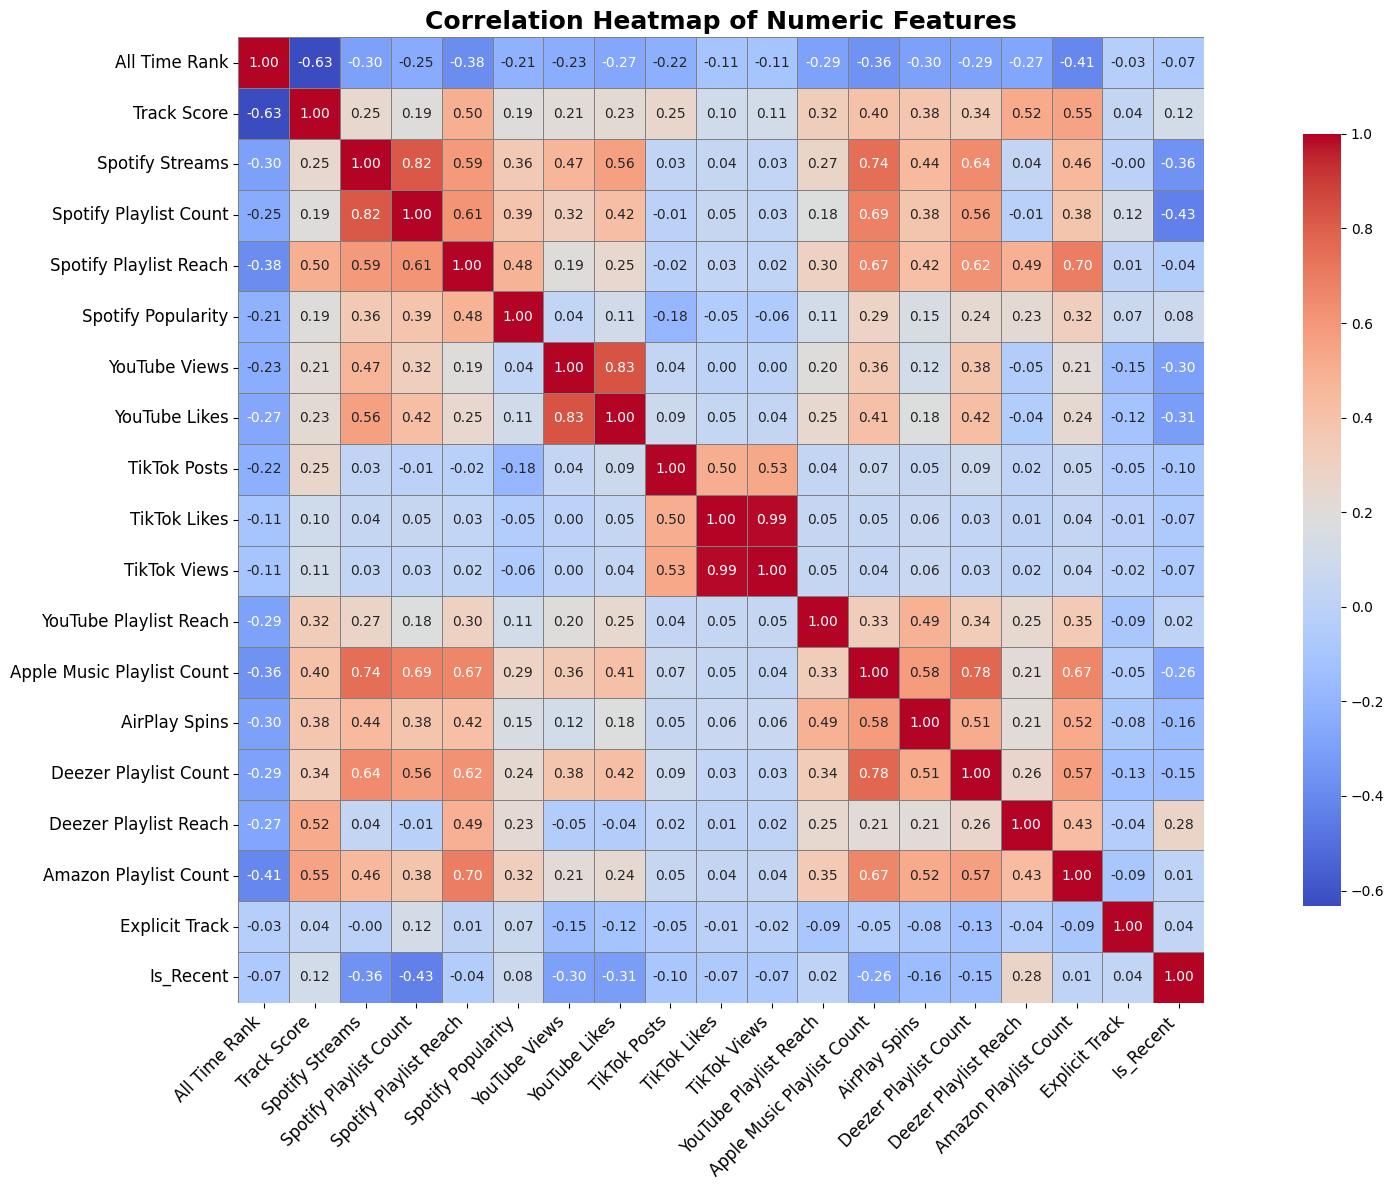

In [33]:
# %% Correlation Heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 12))
corr_matrix = numeric_data.corr()
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .8}, square=True
)
plt.title('Correlation Heatmap of Numeric Features', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [34]:

def plot_boxplots(data):
    """
    Function to plot boxplots for each numeric column in the provided DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The input data containing numeric columns for plotting.
    """
    # Ensure the data contains only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    # Set up the figure grid layout
    num_columns = len(numeric_data.columns)
    num_rows = math.ceil(num_columns / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 5))

    # Flatten the axes array for easier handling (even if only one row or column exists)
    axes = axes.flatten()

    # Define a color palette with as many colors as columns
    palette = sns.color_palette("coolwarm", num_columns)

    # Loop through each numeric column and plot the boxplot, applying individual colors
    for i, column in enumerate(numeric_data.columns):
        sns.boxplot(data=numeric_data[column], ax=axes[i], color=palette[i])
        axes[i].set_title(f'Boxplot of {column}', fontsize=14, weight='bold')
        axes[i].set_xlabel(column, fontsize=12)
        axes[i].set_ylabel('Value')

    # Remove any unused axes (if any exist due to uneven subplot grid)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    
    
    
plot_boxplots(numerical_data)



NameError: name 'numerical_data' is not defined

**Outliers Handling **

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest


def remove_outliers(data, columns, side='both'):
    """
    Function to remove outliers from data.

    Parameters:
    - data (pd.DataFrame): The DataFrame from which we remove outliers.
    - columns (list): List of columns where we want to remove outliers.
    - side (str): Specifies which outliers to remove:
        - 'both' - removes outliers from both sides (upper and lower boundaries),
        - 'upper' - removes outliers only from the upper boundary,
        - 'lower' - removes outliers only from the lower boundary.

    Returns:
    - pd.DataFrame: The DataFrame after removing the outliers.
    """
    
    data_cleaned = data.copy()  # Create a copy of the data to avoid modifying the original
    
    for column in columns:
        Q1 = data_cleaned[column].quantile(0.1)
        Q3 = data_cleaned[column].quantile(0.1)
        IQR = Q3 - Q1
        
        # Calculate the boundaries for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if side == 'both' or side == 'lower':
            # Remove outliers from the lower side
            data_cleaned = data_cleaned[data_cleaned[column] >= lower_bound]
        
        if side == 'both' or side == 'upper':
            # Remove outliers from the upper side
            data_cleaned = data_cleaned[data_cleaned[column] <= upper_bound]
    
    return data_cleaned


def cut_values(data, columns, lower_threshold=None, upper_threshold=None):
    """
    Function to truncate values in specified columns that exceed the thresholds.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the columns to be modified.
    - columns (list): List of columns where values should be truncated.
    - lower_threshold (float, optional): The lower threshold below which values will be clipped.
    - upper_threshold (float, optional): The upper threshold above which values will be clipped.

    Returns:
    - pd.DataFrame: The DataFrame with truncated values.
    """
    
    data_cut = data.copy()  # Create a copy of the data to avoid modifying the original
    
    for column in columns:
        if lower_threshold is not None:
            # Cut values below the lower threshold
            data_cut[column] = data_cut[column].clip(lower=lower_threshold)
        
        if upper_threshold is not None:
            # Cut values above the upper threshold
            data_cut[column] = data_cut[column].clip(upper=upper_threshold)
    
    return data_cut


def remove_outliers_isolation_forest(data, contamination=0.05):
    """
    Removes outliers using the Isolation Forest algorithm.
    
    Parameters:
    - data (pd.DataFrame): The input data to clean.
    - contamination (float): The proportion of outliers in the data (default is 0.05).
    
    Returns:
    - pd.DataFrame: The cleaned data with outliers removed.
    """
    # Initialize the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    
    # Fit the model to the data and predict outliers (1 = inlier, -1 = outlier)
    outliers = iso_forest.fit_predict(data)
    
    # Filter out the outliers
    clean_data = data[outliers == 1]
    
    return clean_data




In [ ]:
print(X_train.isnull().sum())
print("------------------------------------------------")
print(X_val.isnull().sum())


All Time Rank                 0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes                 0
TikTok Posts                  0
TikTok Likes                  0
TikTok Views                  0
YouTube Playlist Reach        0
Apple Music Playlist Count    0
AirPlay Spins                 0
Deezer Playlist Count         0
Deezer Playlist Reach         0
Amazon Playlist Count         0
Explicit Track                0
Is_Recent                     0
Track                         0
Album Name                    0
Artist                        0
Release Date                  0
ISRC                          0
dtype: int64
------------------------------------------------
All Time Rank                   0
Spotify Streams                 0
Spotify Playlist Count          0
Spotify Playlist Reach          0
Spotify Popularity              0
YouTube Views                   

Exporting data sets

In [35]:
import os
import pandas as pd

# Tworzenie folderu, jeśli nie istnieje
folder_name = "datasets"
os.makedirs(folder_name, exist_ok=True)

# Eksport do plików CSV w folderze
X_train.to_csv(os.path.join(folder_name, "X_train.csv"), index=False)
X_val.to_csv(os.path.join(folder_name, "X_val.csv"), index=False)
X_test.to_csv(os.path.join(folder_name, "X_test.csv"), index=False)

y_train.to_csv(os.path.join(folder_name, "y_train.csv"), index=False, header=True)
y_val.to_csv(os.path.join(folder_name, "y_val.csv"), index=False, header=True)
y_test.to_csv(os.path.join(folder_name, "y_test.csv"), index=False, header=True)

print(f"Pliki zostały zapisane w folderze: {folder_name}")


Pliki zostały zapisane w folderze: datasets
